In [69]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import random
from scipy.ndimage import rotate as rtim

ModuleNotFoundError: No module named 'albumentations'

In [2]:
def read_img(img_path):
    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

def display_image(image, title="Image"):
    """
    Display an image using matplotlib. Rembember to use plt.show() to display the image
    """
    plt.imshow(image)
    plt.title(title)
    plt.show()


test xử lý các dạng nhiễu để thử tách nhiễu -> không thấy hiệu quả
nên gray scale ko nhỉ...

In [3]:
img_gt = "wb_localization_dataset/images/train/nlvnpf-0137-01-001.jpg"   #path to the groundtruth image
img = read_img(img_gt)

test xử lý sinh thêm ảnh

In [4]:
# Save an image
def save_image(image, output_path = "generated_dataset/images"):
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [101]:
#Phóng to thu nhỏ
def scale_labels(labels):
    x, y, w, h = map(float, labels)
    scaled_x = x
    scaled_y = y
    scaled_w = w
    scaled_h = h
    scaled_labels = [scaled_x, scaled_y, scaled_w, scaled_h]
    return scaled_labels

def scale_image(image, scale_x, scale_y, interpolation=cv2.INTER_CUBIC):
    width = int(image.shape[1] * scale_x)
    height = int(image.shape[0] * scale_y)
    scaled_image = cv2.resize(image, (width, height), interpolation=interpolation)
    return scaled_image

def handle_scale_labels_file(in_file, out_file):
    with open(out_file, "w") as out:
        pass
    with open(in_file, "r") as f, open(out_file, "w") as out:
        for line in f.readlines():
            coord = list(map(float, line.strip().split()))
            coord[0] = int(coord[0])
            out.write(f"{coord[0]} {coord[1]:.6f} {coord[2]:.6f} {coord[3]:.6f} {coord[4]:.6f}\n")


sinh dataset sau scale 

In [104]:
def handle_scale_convert(images_folder, labels_folder):
    out_folder = "generated_dataset/"
    out_images = out_folder + "images/val/"
    out_labels = out_folder + "labels/val/"

    for filename in os.listdir(images_folder):
        if filename.endswith(".jpg"):
            scale_x = round(random.uniform(0.5, 2), 1)
            scale_y = round(random.uniform(0.5, 2), 1)   
            image_file = os.path.join(images_folder, filename)
            out_img_name = out_images + "__scale__" + filename
            image = read_img(image_file)
            scaled_image = scale_image(image, scale_x, scale_y)
            save_image(scaled_image, out_img_name)


    for filename in os.listdir(labels_folder):
        if filename.endswith(".txt"):
            label_file = os.path.join(labels_folder, filename)
            out_label_name = out_labels + "__scale__" + filename
            handle_scale_labels_file(label_file, out_label_name)

handle_scale_convert("wb_localization_dataset/images/val", "wb_localization_dataset/labels/val")

sinh dataset xoay ảnh

In [47]:
with open("generated_dataset/labels/test_rotate1.txt", "r") as f, open("labels_new/train/test.txt", "w") as out:
    for line in f:
        label, x_center, y_center, width, height = line.strip().split()
        x_center, y_center, width, height = map(float, [x_center, y_center, width, height])

        # Convert coordinates
        x_upper_left = x_center - (width / 2)
        y_upper_left = y_center - (height / 2)
        x_lower_right = x_center + (width / 2)
        y_lower_right = y_center + (height / 2)

        # Write the new coordinates to the output file
        out.write(f"{label} {x_upper_left:.6f} {y_upper_left:.6f} {x_lower_right:.6f} {y_lower_right:.6f}\n")

In [63]:
def rotate_around_point(origin, point, angle):
    radians = math.radians(angle)
    x, y = point
    ox, oy = origin

    dx = x - ox
    dy = y - oy

    rotated_x = ox + dx * math.cos(radians) - dy * math.sin(radians)
    rotated_y = oy + dx * math.sin(radians) + dy * math.cos(radians)

    return rotated_x, rotated_y



def rotate_labels(labels, angle, img_w, img_h, ratio):
    radians = math.radians(angle)

    x, y, w, h= labels
    ox = (img_w / 2) * ratio
    oy = (img_h / 2) * ratio
    # Tính toán tọa độ trước khi thay đổi kích thước ảnh
    xn, yn = x * img_w * ratio, y * img_h * ratio
    xp, yp = rotate_around_point((ox, oy), (xn, yn), angle)

    # Chuyển đổi lại thành tọa độ tương đối
    rotated_x = xp / (img_w * ratio)
    rotated_y = yp / (img_w * ratio)
    rotated_labels = [rotated_x, rotated_y, w, h]
    return rotated_labels

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)
    return rotated_image

def expand_rotate_image(image, angle):
    return rtim(image, angle)


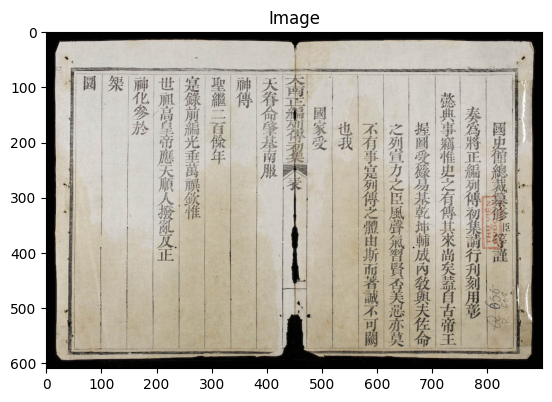

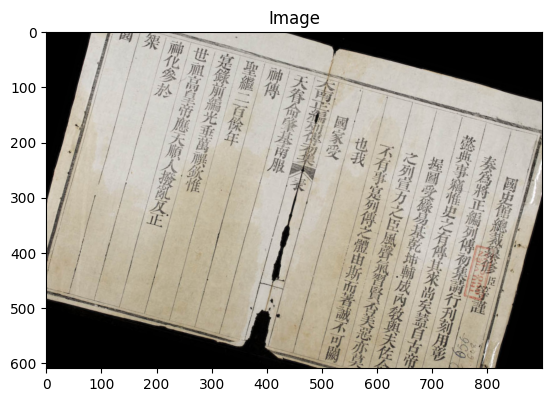

1.0


In [68]:
angle = 15

rotated_img = rotate_image(img, -angle)
display_image(img)
display_image(rotated_img)
save_image(rotated_img, "generated_dataset/images/test_rotate1.jpg")
ratio = rotated_img.shape[0] / img.shape[0]
print(ratio)

label_file = "wb_localization_dataset/labels/train/nlvnpf-0137-01-001.txt"
label_file_out = "generated_dataset/labels/test_rotate1.txt"
with open(label_file_out, "w") as out:
    pass
with open(label_file, "r") as f, open(label_file_out, "w") as out:
    for line in f.readlines():
        cut_line = list(map(float, line.strip().split()[1:]))
        rotated_line = rotate_labels(cut_line, angle, img.shape[0], img.shape[1], ratio)
        out.write(f"{line[0]} {rotated_line[0]:.6f} {rotated_line[1]:.6f} {rotated_line[2]:.6f} {rotated_line[3]:.6f}\n")
        

with open("generated_dataset/labels/test_rotate1.txt", "r") as f, open("labels_new/train/test.txt", "w") as out:
    for line in f:
        label, x_center, y_center, width, height = line.strip().split()
        x_center, y_center, width, height = map(float, [x_center, y_center, width, height])

        # Convert coordinates
        x_upper_left = x_center - (width / 2)
        y_upper_left = y_center - (height / 2)
        x_lower_right = x_center + (width / 2)
        y_lower_right = y_center + (height / 2)

        # Write the new coordinates to the output file
        out.write(f"{label} {x_upper_left:.6f} {y_upper_left:.6f} {x_lower_right:.6f} {y_lower_right:.6f}\n")

In [ ]:
#đổi độ sáng
def adjust_brightness(image, brightness_factor):
    adjusted_image = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)
    return adjusted_image